In [1]:
import spacy
import pandas as pd
import numpy as np

import Modules.solrhandler as sh
#import Modules.decision_tree_bot as cb

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
#query = "anmeldung"
#target_service = 120686

In [4]:
# Import eval.csv
import os
file = os.path.realpath("../../Evaluierung/eval.csv")
eval = pd.read_csv(file, sep = ";")
eval.head(10)

,documentId,file,dialogId,initialQuestion,suggestionCount,directlyFound,name
0,120697,20220131--quantEvalAllExcel.xlsx,4,Ummeldung,6,True,Änderung/Wechsel der Hauptwohnung
1,120686,20220131--quantEvalAllExcel.xlsx,4,Ummelden,6,True,Anmeldung einer Wohnung
2,329421,20220131--quantEvalAllExcel.xlsx,19,Pcr test positiv brauche ich eine Krankschreib...,6,False,Erstattung nach Infektionsschutzgesetz bei Tät...
3,329421,20220131--quantEvalAllExcel.xlsx,19,Quarantäne Krankschreibung vom Arzt,6,True,Erstattung nach Infektionsschutzgesetz bei Tät...
4,120914,20220131--quantEvalAllExcel.xlsx,23,Termin für Zulassung Gebrauchtwagen,6,True,Zulassung eines Fahrzeuges mit auswärtigem Ken...
5,328200,20220131--quantEvalAllExcel.xlsx,24,Wo kann ich mich nach Corona Infektion freites...,6,True,Infektionskrankheiten melden - für Gemeinschaf...
6,330073,20220131--quantEvalAllExcel.xlsx,28,Ab wann ist man bei Johnson & Johnson geboostert,5,True,Impfung gegen Corona (SARS-CoV-2)
7,120702,20220131--quantEvalAllExcel.xlsx,36,Genesenen Bescheinigung,6,True,Meldebescheinigung beantragen
8,330150,20220131--quantEvalAllExcel.xlsx,39,"welche medikamente kann man nehmen, wenn man c...",6,True,Arzneimittel - zur Sachkundeprüfung für den Ha...
9,330174,20220131--quantEvalAllExcel.xlsx,47,ab 15.1. ist für Gäste von Restaurants Nachwe...,6,True,Gaststättengewerbe - zum Unterrichtungsnachwei...


Funktionen

In [5]:
def findCorrectAnswer(chatbot,targetService): # NEU
    
    
    
    temp = chatbot.df#.reset_index(drop=True)
    #index = np.where(temp["id"].values == targetService) # TODO
    #print(temp["id"] == str(targetService))
    if(not any(temp["id"] == str(targetService))):
        #print("not any")
        return None
    
    index = temp.index[temp["id"] == str(targetService)].tolist()[0]
    #print(index)
    bin_vector = chatbot.getBinVector(right = True)
    if bin_vector[index] == 1:
        return True
    elif bin_vector[index] == 0:
        bin_vector = chatbot.getBinVector(right = False)
        if bin_vector[index] == 0:
            return None
        return False
    else:
        print("asdafasdg")
        return None
    

def getRank(chatbot, targetService):
    temp = chatbot.df.reset_index()
    #print(temp["id"])
    #print(targetService)
    rank = temp.index[temp["id"]==str(targetService)].values[0]
    return rank

TEST

In [6]:
import spacy
import pandas as pd
import numpy as np

import Modules.solrhandler as sh
import Modules.clusterer as cls

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import tree

from sklearn.tree import export_text

import matplotlib.pyplot as plt


# TODO import jannis
def init_vector(df,col_name="ssdsLemma"):
    #initiates the word-occurence & frequency vector and list of words
    vectorizer = CountVectorizer()
    a = vectorizer.fit_transform(df[f"{col_name}_processed"]).toarray()
    b = a > 0
    word_occ = b.astype(int)
    words = vectorizer.get_feature_names()
    word_freq=word_occ.sum(axis=0).tolist()
    return word_occ, words, word_freq

class DecisionTreeChatbot:


    def __init__(self, tree_model = tree.DecisionTreeClassifier(criterion = "entropy", random_state = 1), solr = sh.SolrHandler(5), nlp = spacy.load('de_core_news_lg')):
        self.tree_model = tree_model
        self.solr = solr
        self.nlp = nlp
        
        self.df = None
        self.node = 0
        
        # Jannis output
        self.matrix = None
        self.keywords = None
        self.frequencies = None
        

    def initQuery(self, query, printTree = True):
        self.tree_model = tree.DecisionTreeClassifier(criterion = "entropy", random_state = 1)
        
        self.df = self.solr.get_df_from_query(query)
        self.df = cls.process_df_col(self.df, "ssdsLemma", self.nlp)
        
        self.matrix, self.keywords, self.frequencies = init_vector(self.df, "ssdsLemma")
        
        #tree_model = tree.DecisionTreeClassifier(criterion = "entropy", random_state = 1) # TODO
        self.tree_model.fit(self.matrix, self.df["id"])
        
        if printTree:
            self.printTree()
            
        # Handling wenn nur ein ergebnis

    def refine(self, answer):

        # Check if finished # TODO Node before vs node after check
        if len(self.df.index) < 2:
            return False
        
        #refinement
        
        tree = self.tree_model.tree_

        bin_vector = self.getBinVector(answer)
        #print(np.where(bin_vector == 1)) # TODO Wrong behavior
        self.df = self.df.loc[np.where(bin_vector == 1)]#.reset_index(drop=True)
        
        if answer: 
            self.node = tree.children_right[self.node]
        else:
            self.node = tree.children_left[self.node]
            
        if len(self.df.index) < 2:
            return False
            
        return True
    
    def getBinVector(self, right = True): # gibt an welche services rechts / links sind [0,0,0,1] <- samples
        tree = self.tree_model.tree_
        if right:
            return tree.value[tree.children_right[self.node]][0]
        else:
            return tree.value[tree.children_left[self.node]][0]

    def generateQuestion(self):
        return "Geht es bei ihrem Anliegen um " + self.getKeyword() + "?"

    def getKeyword(self):
        structure = self.tree_model.tree_
        feature = structure.feature[self.node]
        return self.keywords[feature] #names[structure.feature[clf.tree_.children_right[0]]]

    def getResult(self):
        return self.df
    
    def printTree(self):
        text = export_text(self.tree_model, feature_names = self.keywords)
        print(text)
        
    def plotTree(self):
        plt.figure(figsize=(12,12))  # set plot size (denoted in inches)
        #class_names = self.df["d115Name"]
        class_names = self.df["id"]
        tree.plot_tree(self.tree_model,feature_names = self.keywords, fontsize=10, class_names = class_names) # TODO , class_names = class_names
        plt.show()


Test init

Ab wann ist man bei Johnson & Johnson geboostert
330073


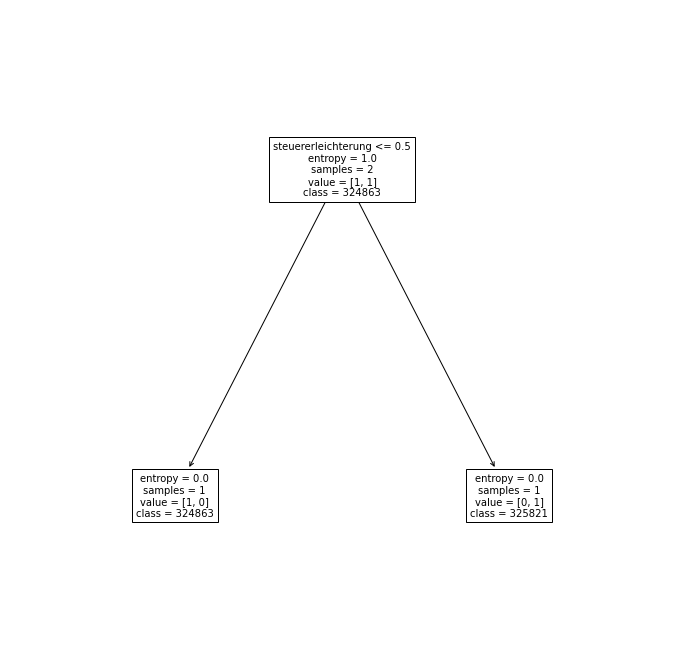

In [7]:
#query = "Quarantäne Krankschreibung vom Arzt"
#service = "329421"

index = 6

query = str(eval["initialQuestion"][index])
service = str(eval["documentId"][index])

print(query)
print(service)

solrhandler = sh.SolrHandler(20)
chatbot = DecisionTreeChatbot(solr = solrhandler)
chatbot.initQuery(query, False)
chatbot.plotTree()
#chatbot.printTree()



In [9]:
solrhandler = sh.SolrHandler(20)
df = solrhandler.get_df_from_query(query)
df.head(20)

,id,d115Url,d115Name,ssdsAll,d115DocumentBoostValue,d115Description,d115Synonym,d115Kennung,d115Verrichtung,d115VerrichtungDetail,...,ssdsVerrichtung,ssdsVerrichtungDict,ssdsVerrichtungDetail,ssdsVerrichtungDetailDict,ssdsSynonym,ssdsSynonymDict,_version_,d115Forms,d115WebLinks,d115ServiceResponsibility
0,324863,https://service.berlin.de/dienstleistung/324863/,Niederlassungserlaubnis für Kinder (ab 16 Jahre),[Niederlassungserlaubnis für Kinder (ab 16 Jah...,1.000000,Erteilung einer Niederlassungserlaubnis für Au...,"[Niederlassungserlaubnis, Jugendliche, Familie...",Niederlassungserlaubnis,beantragen,,...,"[Erteilung, beantragen]","[Erteilung, beantragen]",[für minderjährige Kinder],[für minderjährige Kinder],"[Niederlassungserlaubnis, Jugendliche, Familie...","[Niederlassungserlaubnis, Jugendliche, Familie...",1727918340640342016,NaN,NaN,NaN
1,325821,https://service.berlin.de/dienstleistung/325821/,Freibeträge für Kinder ab 18 Jahren (Besonderh...,[Freibeträge für Kinder ab 18 Jahren (Besonder...,1.197611,Kinderfreibeträge verringern Ihre Einkommenste...,"[Freibetrag, Einkommenssteuer, Kinderfreibeträ...",Lohnsteuerkarte,ändern,wegen geändertem Kinderfreibetrag,...,"[Eintragung, ändern]","[Eintragung, ändern]","[wegen geändertem Kinderfreibetrag, für Kinder...","[wegen geändertem Kinderfreibetrag, für Kinder...","[Freibetrag, Kinderfreibeträge, Steuern, steue...","[Freibetrag, Kinderfreibeträge, Steuern, steue...",1727918341004197888,"[{""name"":""Anlage Kinder zum Antrag auf Lohnste...","[{""name"":""Fragen zu Kindergeld und Kinderfreib...",Zuständig ist das Finanzamt Ihres Wohnsitzes.


In [ ]:
print(chatbot.generateQuestion())
print(findCorrectAnswer(chatbot, service))

In [ ]:
chatbot.refine(True)

In [ ]:
chatbot.refine(False)

In [7]:
chatbot.getResult()

,id,d115Url,d115Name,ssdsAll,d115DocumentBoostValue,d115Description,d115Synonym,d115Kennung,d115Verrichtung,d115VerrichtungDetail,...,ssdsVerrichtungDict,ssdsVerrichtungDetail,ssdsVerrichtungDetailDict,ssdsSynonym,ssdsSynonymDict,_version_,d115Forms,d115WebLinks,d115ServiceResponsibility,ssdsLemma_processed
0,324863,https://service.berlin.de/dienstleistung/324863/,Niederlassungserlaubnis für Kinder (ab 16 Jahre),[Niederlassungserlaubnis für Kinder (ab 16 Jah...,1.000000,Erteilung einer Niederlassungserlaubnis für Au...,"[Niederlassungserlaubnis, Jugendliche, Familie...",Niederlassungserlaubnis,beantragen,,...,"[Erteilung, beantragen]",[für minderjährige Kinder],[für minderjährige Kinder],"[Niederlassungserlaubnis, Jugendliche, Familie...","[Niederlassungserlaubnis, Jugendliche, Familie...",1727918340640342016,NaN,NaN,NaN,erteilung 16 niederlassungserlaubnis kind juge...
1,325821,https://service.berlin.de/dienstleistung/325821/,Freibeträge für Kinder ab 18 Jahren (Besonderh...,[Freibeträge für Kinder ab 18 Jahren (Besonder...,1.197611,Kinderfreibeträge verringern Ihre Einkommenste...,"[Freibetrag, Einkommenssteuer, Kinderfreibeträ...",Lohnsteuerkarte,ändern,wegen geändertem Kinderfreibetrag,...,"[Eintragung, ändern]","[wegen geändertem Kinderfreibetrag, für Kinder...","[wegen geändertem Kinderfreibetrag, für Kinder...","[Freibetrag, Kinderfreibeträge, Steuern, steue...","[Freibetrag, Kinderfreibeträge, Steuern, steue...",1727918341004197888,"[{""name"":""Anlage Kinder zum Antrag auf Lohnste...","[{""name"":""Fragen zu Kindergeld und Kinderfreib...",Zuständig ist das Finanzamt Ihres Wohnsitzes.,lohnsteuerkart bruttogehalt steuerpflichtig än...


Test auto

In [ ]:
print(chatbot.generateQuestion())
answer = findCorrectAnswer(chatbot, service)
print(answer)
while chatbot.refine(answer):
    answer = findCorrectAnswer(chatbot, service)
    print(chatbot.generateQuestion())
    print(answer)
chatbot.getResult()

Logging

In [ ]:
class Logger:
    
    def __init__(self, chatbot, eval_df):
        self.liste = []
        self.chatbot = chatbot
        self.eval_df = eval_df
    
    def getDataFrame(self): # TODO
        pass
    
    def log(self, ID, t, row, answer = None): 
        target_service = row["documentId"]
        
        dialogId = row["dialogId"]
        file = row["file"]
        
        service_name = row["name"]
        query = row["initialQuestion"]
        
        if t == 0:
            pass
            
        
        if answer is not None:

            
            nResults = len(self.chatbot.df.index)
            question = self.chatbot.generateQuestion()
            answer = answer

            rank = getRank(self.chatbot,target_service)# getRank(target_service)
            
            row = (file, dialogId, ID, t,  service_name, query, question, answer, rank, nResults)
        else:
            #nInitialResults = len(chatbot.df.index)
            #initialRank = np.nan
            row = (file, dialogId, ID, t, service_name, query, None, None, None, None)
        self.liste.append(row)
        #print(self.liste)
        #print(str(row))

Execution

In [ ]:
# Initialisierung Komponenten Chatbot
solrhandler = sh.SolrHandler(20)
chatbot = DecisionTreeChatbot(solr = solrhandler)

In [ ]:
# Experiment durchlaufen und Loggen
sub_eval = eval.head(10)
lg = Logger(chatbot,sub_eval)   

for (ID, row) in sub_eval.iterrows():
    
    # fun
    query = row["initialQuestion"]
    target_service = str(row["documentId"])
    
    # Log
    try:
        chatbot.initQuery(query, False)
    except Exception as e:
        if(str(e) == 'response'): # TODO ??
            next
        elif(str(e) == 'no solr output'):
            next
        else:
            print(e)
    t = 0
    answer = findCorrectAnswer(chatbot, target_service)
    lg.log(ID,t, row, answer)
    
    if answer is None:
        continue
    
    while chatbot.refine(answer):
        
        # log
        t += 1
        answer = findCorrectAnswer(chatbot, target_service)
        lg.log(ID, t, row,answer)
        
        if answer is None:
            break
    lg.log(ID, t+1, row,answer)

In [ ]:
log_df = pd.DataFrame(lg.liste, columns=["file","dialogId", "ID","t", "service_name", "query", "question", "answer", "rank", "nResults"])
log_df["rank"] = log_df["rank"]+1
log_df.head(20)

Statistics

In [ ]:
# avg Rank Improvement in turn t
log_df["rank_improvement"] = log_df.groupby(["ID"])["rank"].diff()
log_df.groupby(["t"])["rank_improvement"].mean()

In [ ]:
# avg nSuggestions Improvement in turn t
log_df["sugg_improvement"] = log_df.groupby(["ID"])["nResults"].diff()
log_df.groupby(["t"])["sugg_improvement"].mean()

In [ ]:
# MRR ohne cluster refinement
df = log_df.loc[log_df["t"] == 0]
MRR_ohne = 1/(df["rank"].mean())
MRR_ohne

In [ ]:
# MRR mit cluster refinement
df = log_df.groupby(["ID"]).last("t")
MRR_mit = 1/(df["rank"].mean())
MRR_mit
#df.head()

In [ ]:
# avg Turns (Achtun!) -> chatbot geht noch nicht bis auf einzelnen service herunter weil je nachdem alle in einem cluster
print(log_df["t"].mean())

# bei durchschnittlich nResults
print(log_df.groupby(["ID"]).last("t")["nResults"].mean())